# Spatial Dependency Index

In this tutorial, we will learn how to estimate the **spatial dependency index**. Algorithm is based on the work:

> [1] CAMBARDELLA, C.A.; MOORMAN, T.B.; PARKIN, T.B.; KARLEN, D.L.; NOVAK, J.M.; TURCO, R.F.; KONOPKA, A.E. Field-scale variability of soil properties in central Iowa soils. Soil Science Society of America Journal, v. 58, n. 5, p. 1501-1511, 1994.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
- **Package**:
  - `TheoreticalVariogram`
- **Programming**:
  - Python basics

## Table of contents

1. What is the spatial dependency index?
2. Why do we use spatial dependency index?
3. Example: The comparison of different Spatial Dependence Index over the same extent but different elements.
4. API links.

## What is the spatial dependency index?

The spatial dependency index (SDI) measures the strength of a spatial process we are modeling. SDI is normalized to the interval between 0 and 1. Therefore, we can transform it into percentages and assign an order of spatial dependency from weak to strong.

The SDI is a ratio of the nugget to the total variance (sill) of a model:

$$SDI = \frac{nugget}{sill} * 100$$

Whenever we fit a theoretical variogram with the pyinterpolate package, SDI is calculated, and we will take advantage of it in the examples. Two values represent SDI:

- **numeric**, a ratio of nugget and sill in percent,
- **categorical**, a description of a spatial dependency strength.

There are four levels of spatial dependency.

| Lower Limit (included)       | Upper Limit (excluded) | Strength              |
|------------------------------|------------------------|-----------------------|
| 0                            | 25                     | strong                |
| 25                           | 75                     | moderate              |
| 75                           | 95                     | weak                  |
| 95                           | inf                    | no spatial dependence |

**The lower the ratio, the more substantial is spatial dependence**. If the ratio is greater than 75 percent, we should be cautious with spatial modeling because spatial similarities at analysed scale may not explain the process.




## 2. Why do we use Spatial Dependency Index?

In a world where Tobler’s Law can be applied to every spatial phenomenon, we might always use kriging without consideration. We know that spatial dependence exists, and close neighbors are always similar.

This world is not our world! Not every process follows Tobler’s Law. We can find different elements and chemical compounds sampled over the same area and in the same scale, but their concentrations might be distributed randomly, without any spatial dependency. The example can be seen in publication [1].

The spatial dependence index level is the first indicator that we can use to decide what to do next with a spatial dataset:

- Strong: just krige it!
- Moderate: there might be some other thing that explains process variation.
- Weak: the other non-spatial process has more influence on data than spatial similarities.
- No spatial dependence: the process is random, or spatial dependencies cannot explain variance.

**Note**: Be careful! The last two points are red flags, BUT sometimes processes with a low variogram variability at one scale may be explained with spatial relations at a changed scale. A practical example is a comparison of rental apartment pricing: if you look at the scale of hundreds of kilometers - multiple cities within a country, the spatial dependence may be very weak or none. On the other hand, the spatial similarity between prices of apartments close to each other (up to 10 kilometers, 6 miles) tends to show a classic variogram curve. The reason is simple: most managers and algorithms use information about pricing of the closest neighbors, and neighborhood prices are affected by the same external objects or events.

## 3. Example: Spatial Dependence over the same study extent but for different elements

We will compare the spatial dependence index of four elements: cadmium, copper, lead, and zinc. We use the meuse dataset. The dataset comes from:

```Pebesma, Edzer. (2009). The meuse data set: a tutorial for the gstat R package -> [link to the publication](https://cran.r-project.org/web/packages/gstat/vignettes/gstat.pdf)```

In [1]:
import numpy as np
import pandas as pd
import pyinterpolate as ptp

In [2]:
MEUSE_FILE = '../data/meuse/meuse.csv'

# Variogram parameters
STEP_SIZE = 100
MAX_RANGE = 1600
ALLOWED_MODELS = 'safe'


# Elements
ELEMENTS = ['cadmium', 'copper', 'zinc', 'lead']
COLS = ['x', 'y']
COLS.extend(ELEMENTS)

In [3]:
df = pd.read_csv(MEUSE_FILE, usecols=COLS)
df.head()

,x,y,cadmium,copper,lead,zinc
0,181072,333611,11.7,85,299,1022
1,181025,333558,8.6,81,277,1141
2,181165,333537,6.5,68,199,640
3,181298,333484,2.6,81,116,257
4,181307,333330,2.8,48,117,269


Data is skewed for every element in the table. Before we start variogram modeling, we must transform data to reduce skewness, and make data distribution closer to normal. We will use a logarithmic transform, pass data into an experimental variogram, and then create theoretical models. We will use grid search to find the best possible nugget value.

Optimal model for element cadmium has 43.96% of nugget to sill ratio. Spatial Dependence is moderate.


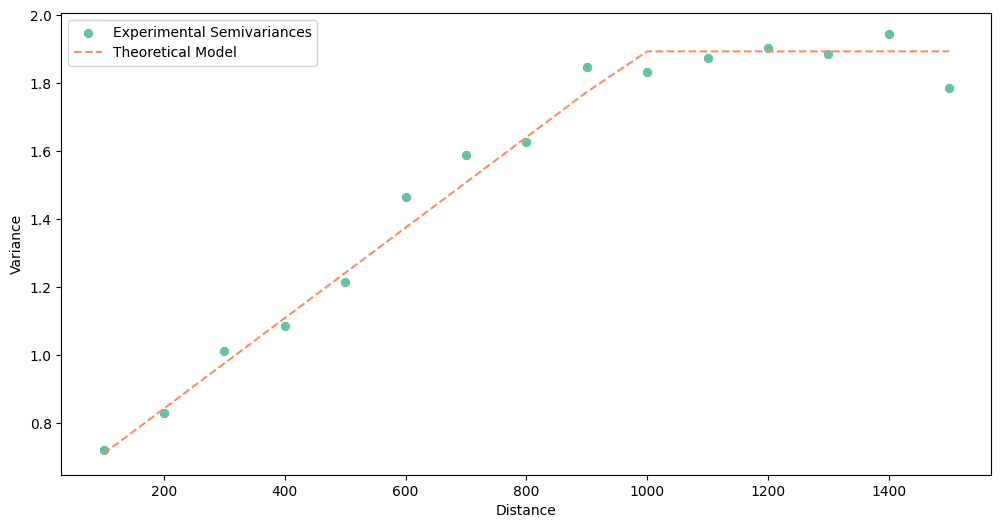


---

Optimal model for element copper has 26.08% of nugget to sill ratio. Spatial Dependence is moderate.


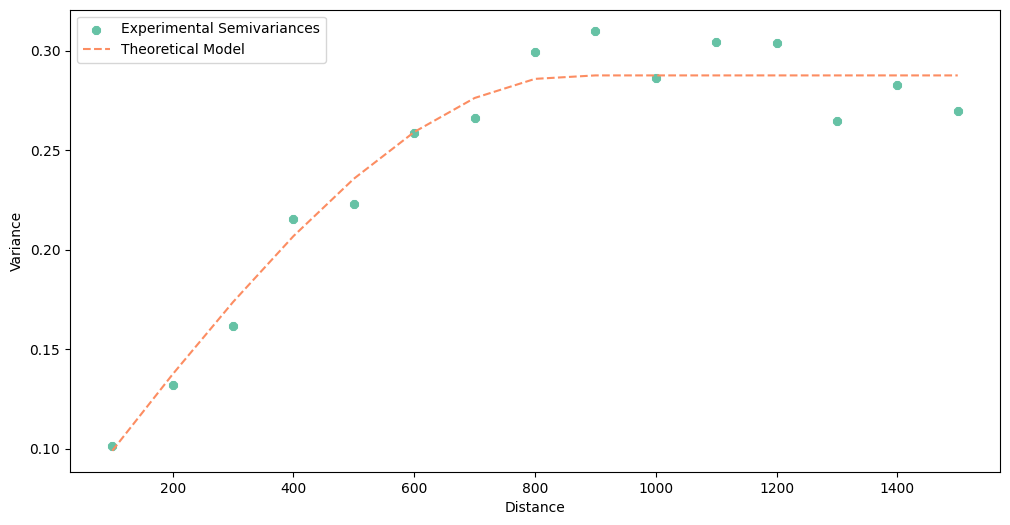


---

Optimal model for element zinc has 1.09% of nugget to sill ratio. Spatial Dependence is strong.


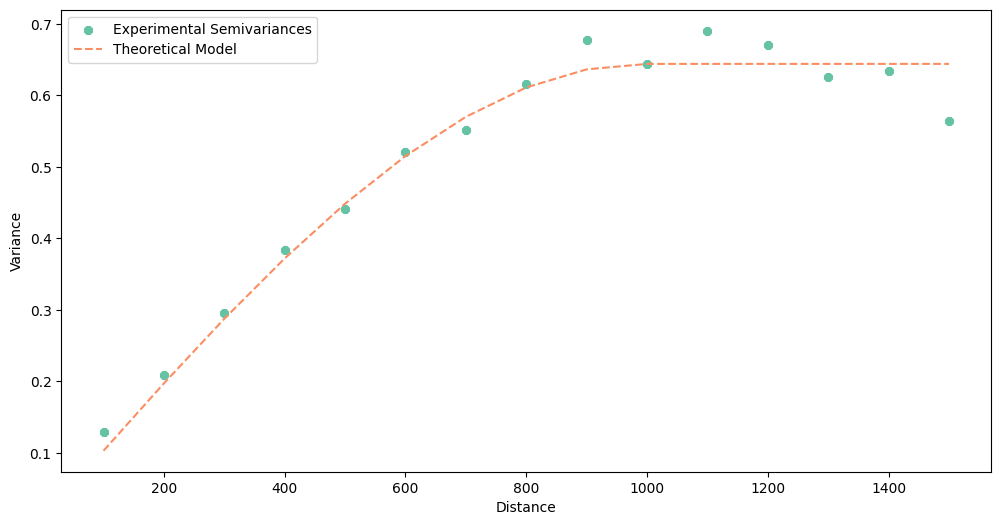


---

Optimal model for element lead has 14.34% of nugget to sill ratio. Spatial Dependence is strong.


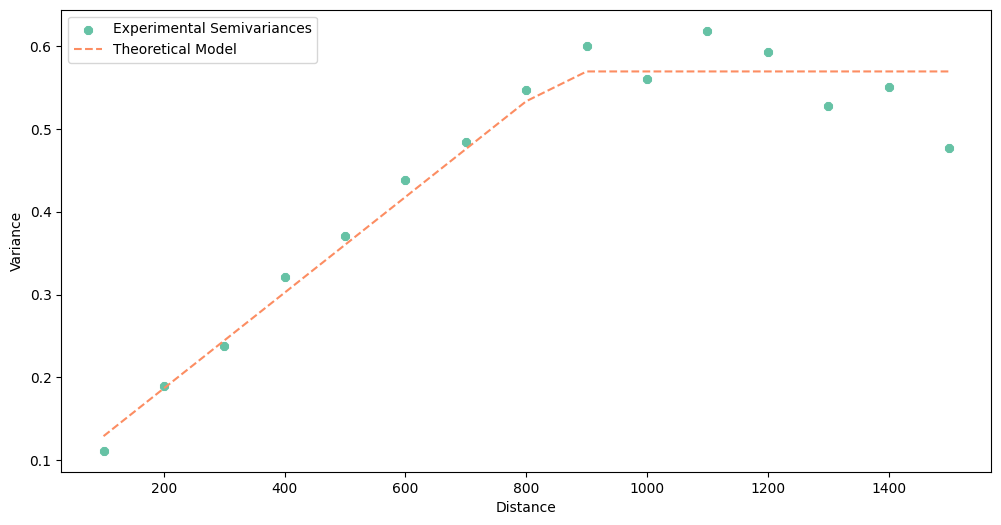


---



In [5]:
for element in ELEMENTS:
    # Prepare data
    ds = df[['x', 'y', element]].copy()
    ds[element] = np.log(ds[element])
    arr = ds.values

    # Get experimental variogram
    exp_var = ptp.build_experimental_variogram(arr, step_size=STEP_SIZE, max_range=MAX_RANGE)

    # Find optimal theoretical model
    optimal_model = ptp.TheoreticalVariogram()
    optimal_model.autofit(experimental_variogram=exp_var, models_group=ALLOWED_MODELS, max_nugget=0.8)
    print('Optimal model for element {} has {:.2f}% of nugget to sill ratio. Spatial Dependence is {}.'.format(
        element, optimal_model.spatial_dependency_ratio, optimal_model.spatial_dependency_strength
    ))
    optimal_model.plot()

    print('\n---\n')

The strength of spatial dependence differs mostly between Cadmium and other elements.

## 4. API

The spatial dependence index may be calculated directly with the `calculate_spatial_dependence_index()` function that takes two parameters: `nugget` and `sill`. It returns `Tuple` with spatial dependence ratio and spatial dependence strength.

Another way is to calculate `TheoreticalVariogram` with a grid search option for nugget (just leave the `nugget` parameter as `None` and the algorithm will find the optimal `nugget` value).

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-04-23 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |